Import useful libraries

In [55]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis dataset 1

Specify folders from which to get configurations and set the values of the yukawa couling used in the simulations

In [56]:
folders = ["dataset1/s_0_25/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_1_0/conf" + str(i+1) for i in range(10)]
Nt0 = 16
Nx0 = 16
yukawa = [1e-5, 1e-2, 2e-2, 1e-1, 2e-1, 1.0, 2.0, 1e1, 2e1, 1e2]


Import functions from Jan Philipp's code

In [57]:
from correlations import *
from read_in_data import *
from mass_fit import *
from mass_matteo import *

Load data from specified folders

In [66]:
phi = {}
cond = {}
absphi = {}
chi2 = {}
mr = {}
mqphys = {}
cutoffs = []

for f in folders:
    print(f)
    params = toml.load("data/" + f + "/input.toml") # read toml file with parameters

    s = str(params['physics']['cutFraction']) # read cutoff
    # if cutoff is not already in the list, add it and create the corresponding data arrays
    if not (float(s) in cutoffs):
        cutoffs.append(float(s))
        phi[s] = []
        cond[s] = []
        chi2[s] = []
        mr[s] = []
        mqphys[s] = []

    Nt = int(Nt0 / float(s))
    Nx = int(Nx0 / float(s))
    volume = (Nt, Nx)
    
    g = float(params['fermions']['yukawa_coupling']) # read yukawa coupling
    
    print("cutFractions:", s, " Yukawa:", g)

    data = read_csv("data/" + f + "/traces.csv") # read file with magnetisation, condensate, ...

    # Get bosonic time slices computed in main.cu
    S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
    # Get fermionic time slices computed in main.cu
    data_Sq_t = read_csv("data/" + f + "/data.csv")
    Sq_t = data_Sq_t['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

    # magnetisation
    val, err = get_mag(data['sigma'].to_numpy())
    phi[s].append((val, err, g))
    # condensate
    val, err = get_mag(data['tr'].to_numpy())
    cond[s].append((val, err, g))
    # susceptibility
    val, err = get_chi2(data['sigma'].to_numpy())
    chi2[s].append((val, err, g))
    # renormalised bosonic mass
    val, err = get_ren_mass_right_via_timeslices(S_t,volume)
    mr[s].append((val, err, g))
    # physical quark mass
    val, err = get_phys_quark_mass_via_timeslices(S_t,volume)
    mqphys[s].append((val, err, g))
    
    print()

for k in phi.keys():
    phi[k] = sorted(phi[k], key=lambda x: x[2])
    cond[k] = sorted(cond[k], key=lambda x: x[2])
    chi2[k] = sorted(chi2[k], key=lambda x: x[2])
    mr[k] = sorted(mr[k], key=lambda x: x[2])
    mqphys[k] = sorted(mqphys[k], key=lambda x: x[2])

dataset1/s_0_25/conf1
cutFractions: 0.25  Yukawa: 0.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 91809.30it/s]



dataset1/s_0_25/conf2
cutFractions: 0.25  Yukawa: 0.01


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 92298.92it/s]



dataset1/s_0_25/conf3
cutFractions: 0.25  Yukawa: 0.02


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 94594.64it/s]



dataset1/s_0_25/conf4
cutFractions: 0.25  Yukawa: 0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 90333.83it/s]



dataset1/s_0_25/conf5
cutFractions: 0.25  Yukawa: 0.2


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 90226.80it/s]



dataset1/s_0_25/conf6
cutFractions: 0.25  Yukawa: 1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90071.10it/s]



dataset1/s_0_25/conf7
cutFractions: 0.25  Yukawa: 2.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 89874.91it/s]



dataset1/s_0_25/conf8
cutFractions: 0.25  Yukawa: 10.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 88446.57it/s]



dataset1/s_0_25/conf9
cutFractions: 0.25  Yukawa: 20.0


100%|████████████████████████████████████| 9946/9946 [00:00<00:00, 89616.45it/s]



dataset1/s_0_25/conf10
cutFractions: 0.25  Yukawa: 100.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90998.59it/s]



dataset1/s_0_5/conf1
cutFractions: 0.5  Yukawa: 0.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90139.39it/s]



dataset1/s_0_5/conf2
cutFractions: 0.5  Yukawa: 0.01


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 88859.31it/s]



dataset1/s_0_5/conf3
cutFractions: 0.5  Yukawa: 0.1


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 89691.46it/s]



dataset1/s_0_5/conf4
cutFractions: 0.5  Yukawa: 1.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 88778.16it/s]



dataset1/s_0_5/conf5
cutFractions: 0.5  Yukawa: 10.0


100%|████████████████████████████████████| 9952/9952 [00:00<00:00, 90261.14it/s]



dataset1/s_0_5/conf6
cutFractions: 0.5  Yukawa: 0.02


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 89481.79it/s]



dataset1/s_0_5/conf7
cutFractions: 0.5  Yukawa: 0.2


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90298.75it/s]



dataset1/s_0_5/conf8
cutFractions: 0.5  Yukawa: 2.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 90424.30it/s]



dataset1/s_0_5/conf9
cutFractions: 0.5  Yukawa: 20.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90178.74it/s]



dataset1/s_0_5/conf10
cutFractions: 0.5  Yukawa: 100.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 88398.85it/s]



dataset1/s_1_0/conf1
cutFractions: 1.0  Yukawa: 0.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 90212.86it/s]



dataset1/s_1_0/conf2
cutFractions: 1.0  Yukawa: 0.01


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 88365.18it/s]



dataset1/s_1_0/conf3
cutFractions: 1.0  Yukawa: 0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 87435.34it/s]



dataset1/s_1_0/conf4
cutFractions: 1.0  Yukawa: 1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 88931.52it/s]



dataset1/s_1_0/conf5
cutFractions: 1.0  Yukawa: 10.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 87298.71it/s]



dataset1/s_1_0/conf6
cutFractions: 1.0  Yukawa: 0.02


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 88515.32it/s]



dataset1/s_1_0/conf7
cutFractions: 1.0  Yukawa: 0.2


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 89576.26it/s]



dataset1/s_1_0/conf8
cutFractions: 1.0  Yukawa: 2.0


100%|████████████████████████████████████| 9952/9952 [00:00<00:00, 89284.99it/s]



dataset1/s_1_0/conf9
cutFractions: 1.0  Yukawa: 20.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 88746.16it/s]



dataset1/s_1_0/conf10
cutFractions: 1.0  Yukawa: 100.0


100%|████████████████████████████████████| 9953/9953 [00:00<00:00, 91032.39it/s]

In [67]:
'''IMPORTANT: should I use the one for large t, small t or the whole? 
tmp_ren = []
tmp_large_t = []
tmp_small_t = []

S_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")
tmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)
tmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)
tmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)

ren_masses = tmp_ren
print("ren mass:", val, err)'''

'IMPORTANT: should I use the one for large t, small t or the whole? \ntmp_ren = []\ntmp_large_t = []\ntmp_small_t = []\n\nS_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")\ntmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)\ntmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\ntmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\n\nren_masses = tmp_ren\nprint("ren mass:", val, err)'

# Plot Stuff

### Plot of the magnetization

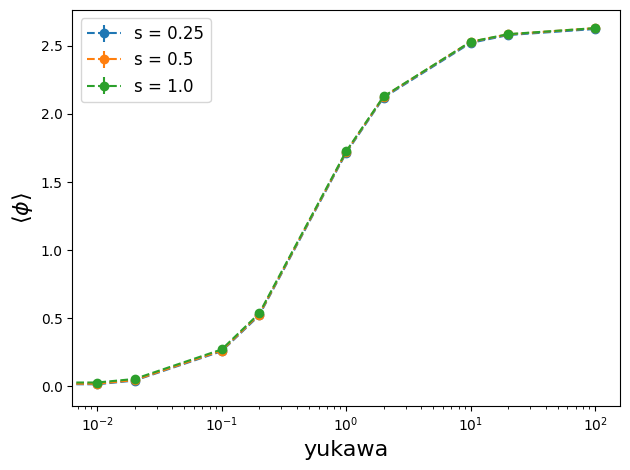

In [68]:
for k in phi.keys():
    plt.errorbar([v[2] for v in phi[k]], [v[0] for v in phi[k]], [v[1] for v in phi[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$\left\langle \phi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the magnetic susceptibility

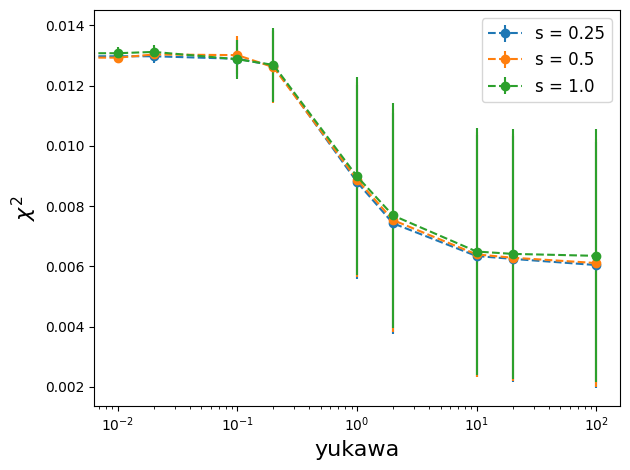

In [69]:
for k in chi2.keys():
    plt.errorbar([v[2] for v in chi2[k]], [v[0] for v in chi2[k]], [v[1] for v in chi2[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$\chi^2$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the condensate

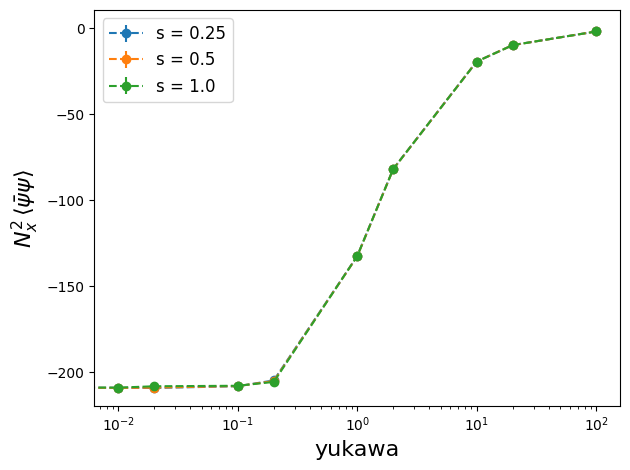

In [70]:
for k in cond.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in cond[k]], [Nx*Nx*v[0] for v in cond[k]], [Nx*Nx*v[1] for v in cond[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$N_x^2 \, \left\langle \bar \psi \psi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the physical quark mass

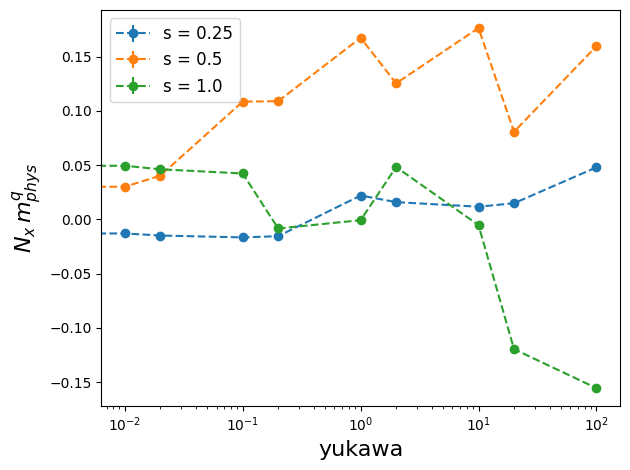

In [71]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mqphys[k]], [Nx*v[0] for v in mqphys[k]], [0 for _ in range(len(mqphys[k]))], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$N_x \, m^q_{phys}$', fontsize=16)
plt.tight_layout()
plt.show()

### Plot of the bosonic renormalised mass

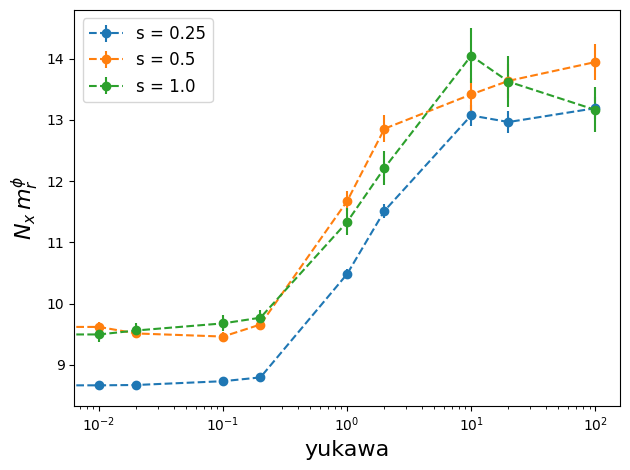

In [52]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mr[k]], [Nx*v[0] for v in mr[k]], [Nx*v[1] for v in mr[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel('yukawa', fontsize=16)
plt.ylabel(r'$N_x \, m^\phi_r$', fontsize=16)
plt.tight_layout()
plt.show()

# Mean Field equations of motion

Reset data arrays

In [35]:
sigma_vals = []
sigma_errs = []
tr_vals = []
tr_errs = []
cutFractions = []

In [36]:
rcParams['text.usetex'] = True

####################################################
folders = ["s1"]
mypath = "data/"
plot_trace = True
####################################################


c = 0
for fold in folders:
    s = []
    data = [] # each element will be a triple (s, sigma, err_sigma)
    data_trace = [] # each element will be a triple (s, condensate, err_condensate)
    for f in os.listdir(mypath + fold):
        
        full_path = mypath + fold + "/" + f + "/"   
        
        params = toml.load(full_path + "/input.toml")
        s = float(params['physics']['cutFraction'])
       
        filedata = read_csv(full_path + "traces.csv")
        N = len(filedata['sigma'])
    
        # vals
        sigma = np.average(filedata['sigma'].to_numpy())
        tr = np.average(filedata['tr'].to_numpy())
        
        print("s =", s, " <|sigma|> = ", sigma, " <|psibar psi|> = ", tr)
        
        # errs
        sigma_err = np.std(filedata['sigma'].to_numpy()) / np.sqrt(N-1)
        tr_err = np.std(filedata['tr'].to_numpy()) / np.sqrt(N-1)
                    
        data.append((s, sigma, sigma_err))
        data_trace.append((s, tr, tr_err))
    
    data = sorted(data, key=lambda x: x[0])
    data_trace = sorted(data_trace, key=lambda x: x[0])
                    
    for el in data:
        cutFractions.append(el[0])
        sigma_vals.append(el[1])
        sigma_errs.append(el[2])
    
    for el in data_trace:
        tr_vals.append(el[1])
        tr_errs.append(el[2])

    plt.errorbar(cutFractions, sigma_vals, yerr=sigma_errs, fmt='o', color=colors[c])
    if plot_trace:
        plt.errorbar(cutFractions, [t/1 for t in tr_vals], yerr=[t/1 for t in tr_errs], fmt='o')

    c += 1
                    
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'data/s1'

# Mass fit
### Fit exponential decay to get the mass

Load data

In [37]:
from scipy.optimize import curve_fit as fit

####################################################
data_folder = "s1/conf6"
Nt = 128
plot = True
####################################################

def fitfuncSinh(x, m_re, A):
    return A * np.sinh(m_re*(Nt/2-x))

def fitToSinh(ydata, startidx, endidx, plot=False):
    yvals = ydata[startidx:endidx]
    xvals = np.array(range(startidx, endidx))

    fitparams = fit(fitfuncSinh, xvals, yvals, p0=[1e-2, 0])
    #print("Mass: ", abs(fitparams[0][0]))
        
    return fitparams[0]

data = read_csv("data/" + data_folder + "/data.csv")
timeslices = data['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

corr = np.average(timeslices, axis=0)

fitparams = fitToSinh(corr, 1, Nt, plot)

print("Mass =", fitparams[0])

plt.plot(range(1, Nt), corr[1:Nt], label="data")
xvals = np.linspace(0, Nt, 1000)
plt.plot(xvals, fitfuncSinh(xvals, fitparams[0], fitparams[1]), label='fit')
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

print("Params: ")
print("mq0:", mq0)
print("g:", yukawa_coupling)
print("Number of data points:", timeslices.shape[0])
print("Nt:", timeslices.shape[1])
print("Measured mass:", fitparams[0])

FileNotFoundError: [Errno 2] No such file or directory: 'data/s1/conf6/data.csv'

Compute expected mass from background fields

In [ ]:
def expectedM(m0, g, sigma, pi):
    r2 = sigma**2 + pi[0]**2 + pi[1]**2 + pi[2]**2
    denom = 2*(g*sigma + m0 + 1)
    sqrroot = np.sqrt((g**2*r2 + 2*m0*(g*sigma + 1) + 2*g*sigma + m0**2 + 2)**2 - 4*(g*sigma+m0+1)**2)
    num = -sqrroot + g**2*r2 + 2*g*m0*sigma + 2*g*sigma + m0**2 + 2*m0 + 2
    return -np.log(num/denom)

mq0 = 0.2
yukawa_coupling = 0.1
sigma = 0.16
pi = [0, 0, 0]

print("Expected mass with phi =", np.concatenate(([sigma], pi)), ":", expectedM(mq0, yukawa_coupling, sigma, pi))